# Testing NASH for textile orientation classification

The Neural Architecture Search by Hill Climbing algorithm is tested on the a dataset of images of fabric in order to classify textile orientation. This classification problem has 8000 images with 8 orientations (i.e. 1000 images per label) for training and as many for testing

The algorithme is described in: [*Thomas Elsken, Jan-Hendrik Metzen, Frank Hutter, **Simple And Efficient rchitecture Search for Convolutional Neural Networks**, arXiV:1711.04528*](https://arxiv.org/abs/1711.04528).

The **nni.networkmorphism_tuner** library from the Microsoft NNI package is used to represent a neural network as a graph and apply function-preserving morphisms.

The dataset is available on [Kaggle](https://www.kaggle.com/dataset/6e98e7fa2ed4166bb10c375c19df2ffb8bbd636687be7ec7338e2fc7fe2ac15e)



## Principle:
The architecture search starts with a very simple CNN. This initial model is trained for 20 epochs.

Mutations, consisting in repeated application of random network morphisms, are made on that model in order to produce a generation of candidate models. Thanks to the function-preserving property of the network morphisms, these candidate models already have their weights initialised so as to exactly replicate the predictions of the parent model. These candidates are further trained for 10 epochs, then evaluated on a cross-validation set. The model with the lowest cross-validation loss is chosen ad the parent for the next generation, and the whole process is repeated.

In [1]:
# prerequisites
import torch
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import time
from torchviz import make_dot
import os

# Custom modules
from datasets import TextureDataset, train_test_split
from augmentations import Cutout
from nash import HillClimbingTuner
import training

In [2]:
print("pytorch",torch.__version__)
print("cuda", torch.version.cuda)
print("cudnn", torch.backends.cudnn.version())
torch.cuda.is_available()


pytorch 1.5.0
cuda 10.1
cudnn 7603


True

In [3]:
# Dataset properties
INPUT_SIZE = 32
INPUT_CHN = 1
N_CLASS = 8

# Training parameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
N_EPOCH_TRAIN = 10

# Search parameters
MODEL_PATH = "test_angles_nash"
MAX_GEN = 4
N_MORPH = 5
GEN_SIZE = 8

## Datasets
The train dataset is split into a subset used to train candidate models and a cross-validation subset. The train subset is augmented with Cutout

In [4]:
test_set = TextureDataset(
                dataset='test32',
                label_type='angles',
                transform=transforms.ToTensor(),
                directory="./textures",
                normalized=False)
train_full = TextureDataset(
                dataset='train32',
                label_type='angles',
                transform=transforms.ToTensor(),
                directory="./textures",
                normalized=False)

train_set, crossval_set = train_test_split(
    train_full,
    train_transform=Cutout(
        default_color = [0],
        patch_size=16,
        input_type="tensor",
        inplace=False
    ),
    test_transform=None,
    ratio=.9)

loader_args = {"batch_size": BATCH_SIZE, "pin_memory": True}

train_loader = torch.utils.data.DataLoader(
    dataset=train_set, shuffle=True, **loader_args)
crossval_loader = torch.utils.data.DataLoader(
    dataset=crossval_set, shuffle=False, drop_last=False, **loader_args)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, shuffle=False, drop_last=False, **loader_args)



## Set-up the tuner
The HillClimbingTuner is a subclass of **nni.networkmorphism_tuner.networkmorphism_tuner.NetworkMorphismTuner** with some methods overloaded so that is runs the NASH algorithm. The tuner object is in charge of providing the models to be trained, retreiving the results after trining and saving the trained models on disk with their parameters.

In [5]:
tuner = HillClimbingTuner(
    task = "cv",
    input_width = INPUT_SIZE,
    input_channel = INPUT_CHN,
    n_output_node = N_CLASS,
    optimize_mode = "minimize",
    path = MODEL_PATH,
    gen_size = GEN_SIZE)

## Training

In [6]:
model_nb = 0
gen_id = 0
n_iter = 0
timing = []
losses = []
accuracies = []
parameters = []
confusion_matrices = []

if os.path.isdir(tuner.path):
    filesToRemove = [os.path.join(tuner.path,f) for f in os.listdir(tuner.path)]
    
    if filesToRemove:
        answ = input("Directory %s exists, overwrite? (Y/n)"%tuner.path)
        while answ not in "Yn":
            answ = input("Directory %s exists, overwrite? (Y/n)"%tuner.path)
        if answ!="Y":
            raise RuntimeError("Directory exists!")

        for f in filesToRemove:
            os.remove(f)

Directory /home/btayart/MS-IA/FilRouge/nash_test/test_angles_nash exists, overwrite? (Y/n)Y


In [7]:
t00 = time.time()
t0 = t00
while gen_id <= MAX_GEN:
    print("\n=========================")
    parameter_id = "gen%02d_model%d"%(gen_id,model_nb)
    print("Iteration %d - %s - %ds elapsed"%(n_iter,parameter_id, t0-t00))
    
    # Get a model from the tuner, train it with an Adam optimiser and Cosine learning rate annealing
    graph = tuner.generate_parameters(parameter_id)
    model = graph.produce_torch_model().cuda()
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    T = N_EPOCH_TRAIN * (2 if n_iter==0 else 1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T)
    
    training.train_net(model, train_loader, optimizer, n_epoch=T, verbose=1, lr_scheduler = scheduler)
    
    # Evaluate on crossvalidation to get performance metrics (and on test just to follow what is happening)
    loss, accuracy, confusion = training.test_net(model, crossval_loader)
    loss_t, accuracy_t, confusion_t = training.test_net(model, test_loader)
    
    # Retrieve parameter weights from the torch.Model object, back into the underlying graph
    model.cpu()
    model.set_weight_to_graph()
    tuner.receive_trial_result(parameter_id, loss, model)  
    
    #Save results
    parameters.append(parameter_id)
    print("Best model so far : %s (%d)"%(parameters[tuner.get_best_model_id()],tuner.get_best_model_id()))
    
    n_iter += 1
    if tuner.training_queue: 
        model_nb += 1
    else:
        gen_id += 1
        model_nb = 0
    
    t1=time.time()
    timing.append(t1-t0)
    t0=t1
    losses.append([loss,loss_t])
    accuracies.append([accuracy,accuracy_t])
    confusion_matrices.append([confusion, confusion_t])
    
tt = t1-t00
h = (tt)//3600
m = (tt - 3600*h)//60
s = (tt - 3600*h - 60*m)//1
print("******** DONE ********")
print("Full NAS search done in %dh %dm %ds seconds"%(h,m,s))

accuracies = np.array(accuracies)
losses = np.array(losses)
timing = np.array(timing)
cm = np.array(confusion_matrices)
arr_path = os.path.join(tuner.path, "metrics.npz")
np.savez(arr_path, timing=timing,
        losses=losses, accuracies=accuracies, confusion_matrices=cm)


Iteration 0 - gen00_model0 - 0s elapsed
Training done, 20 epochs in 26.9s, loss at last epoch: 0.3289
Well classified   757 /   800, (94.62% accuracy)
Average loss : 0.166675
Well classified  7575 /  8000, (94.69% accuracy)
Average loss : 0.169618
Best model so far : gen00_model0 (0)

Iteration 1 - gen01_model0 - 28s elapsed
Training done, 10 epochs in 18.7s, loss at last epoch: 0.2334
Well classified   775 /   800, (96.88% accuracy)
Average loss : 0.097769
Well classified  7717 /  8000, (96.46% accuracy)
Average loss : 0.106050
Best model so far : gen01_model0 (1)

Iteration 2 - gen01_model1 - 48s elapsed
Training done, 10 epochs in 23.4s, loss at last epoch: 0.2039
Well classified   773 /   800, (96.62% accuracy)
Average loss : 0.085669
Well classified  7767 /  8000, (97.09% accuracy)
Average loss : 0.087643
Best model so far : gen01_model1 (2)

Iteration 3 - gen01_model2 - 72s elapsed
Training done, 10 epochs in 19.9s, loss at last epoch: 0.4463
Well classified   769 /   800, (96.1

Training done, 10 epochs in 84.5s, loss at last epoch: 0.0393
Well classified   794 /   800, (99.25% accuracy)
Average loss : 0.017169
Well classified  7949 /  8000, (99.36% accuracy)
Average loss : 0.019807
Best model so far : gen04_model0 (25)

Iteration 27 - gen04_model2 - 1247s elapsed
Training done, 10 epochs in 81.2s, loss at last epoch: 0.0425
Well classified   795 /   800, (99.38% accuracy)
Average loss : 0.016199
Well classified  7953 /  8000, (99.41% accuracy)
Average loss : 0.018024
Best model so far : gen04_model0 (25)

Iteration 28 - gen04_model3 - 1332s elapsed
Training done, 10 epochs in 84.8s, loss at last epoch: 0.0538
Well classified   793 /   800, (99.12% accuracy)
Average loss : 0.034702
Well classified  7906 /  8000, (98.83% accuracy)
Average loss : 0.030230
Best model so far : gen04_model0 (25)

Iteration 29 - gen04_model4 - 1422s elapsed
Training done, 10 epochs in 84.1s, loss at last epoch: 0.0781
Well classified   799 /   800, (99.88% accuracy)
Average loss : 0

## Display results
Now, display the training results, confusion matrix and final graph architecture. 

In [ ]:
def insert_gap(vec, gen_size=GEN_SIZE):
    """Inser a nan in the vector between generations"""
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    last_gen = gen[-1]

    ind = np.empty((n_models+last_gen,))
    ind[:] = np.nan
    val = np.empty((n_models+last_gen,))
    val[:] = np.nan

    ind[model_id+gen] = model_id
    val[model_id+gen] = vec
    return ind, val


def get_best_metric(vec, gen_size=GEN_SIZE):
    """Return id and metric of best model at each generation"""
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    n_gen = gen[-1]+1
    best_id, best_metric = np.zeros((n_gen)), np.zeros((n_gen))
    for ii in range(n_gen):
        imin = vec[gen == ii].argmin()
        shift = 0 if 0 == ii else 1+(ii-1)*gen_size
        best_id[ii] = imin+shift
        best_metric[ii] = vec[imin+shift]
    return best_id, best_metric

def get_best_metric(vec, gen_size=GEN_SIZE):
    """Return id and metric of best model at each generation"""
    n_models = vec.size
    model_id = np.arange(vec.size)
    gen = 1 + (model_id-1)//gen_size
    n_gen = gen[-1]+1
    best_id, best_metric = np.zeros((n_gen)), np.zeros((n_gen))
    for ii in range(n_gen):
        imin = vec[gen == ii].argmin()
        shift = 0 if 0 == ii else 1+(ii-1)*gen_size
        best_id[ii] = imin+shift
        best_metric[ii] = vec[imin+shift]
    return best_id, best_metric

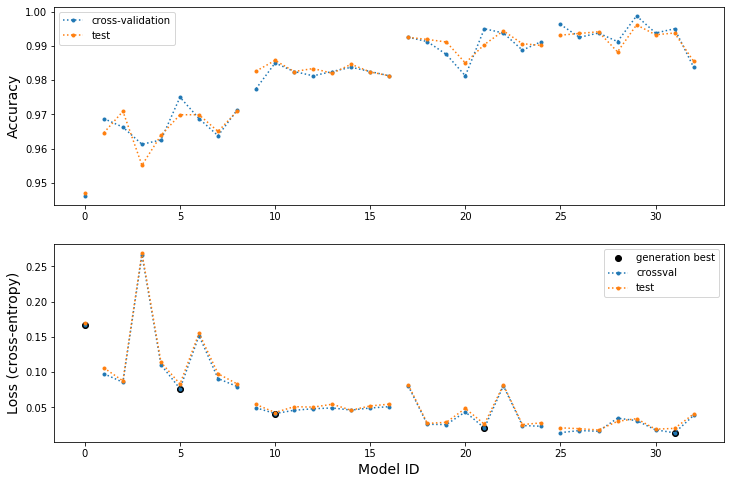

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(*insert_gap(accuracies[:, 0]), ".:", label="cross-validation")
plt.plot(*insert_gap(accuracies[:, 1]), ".:",label="test")
plt.legend()
plt.ylabel("Accuracy", fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(*get_best_metric(losses[:, 0]), "ok", label="generation best")
plt.plot(*insert_gap(losses[:, 0]), ".:",label="crossval")
plt.plot(*insert_gap(losses[:, 1]), ".:",label="test")
plt.ylabel("Loss (cross-entropy)", fontsize=14)
plt.xlabel("Model ID", fontsize=14)
plt.legend();

In [16]:
best_id = tuner.get_best_model_id()
print("The confusion matrix for the best model is:")
print(np.array2string(cm[best_id,1]))
print("Test cross-validation accuracy is %.2f%%"%(accuracies[best_id,0]*100))
print("Test accuracy is %.2f%%"%(accuracies[best_id,1]*100))


The confusion matrix for the best model is:
[[995   0   0   0   5   4   0   0]
 [  0 999   0   0   0   6   1   0]
 [  0   0 991   0   0   0   1   2]
 [  0   0   0 997   1   0   0  12]
 [  2   0   0   0 994   0   0   0]
 [  3   1   0   0   0 990   0   0]
 [  0   0   2   0   0   0 998   0]
 [  0   0   7   3   0   0   0 986]]
Test cross-validation accuracy is 99.50%
Test accuracy is 99.38%


parameters in best model: 2192960


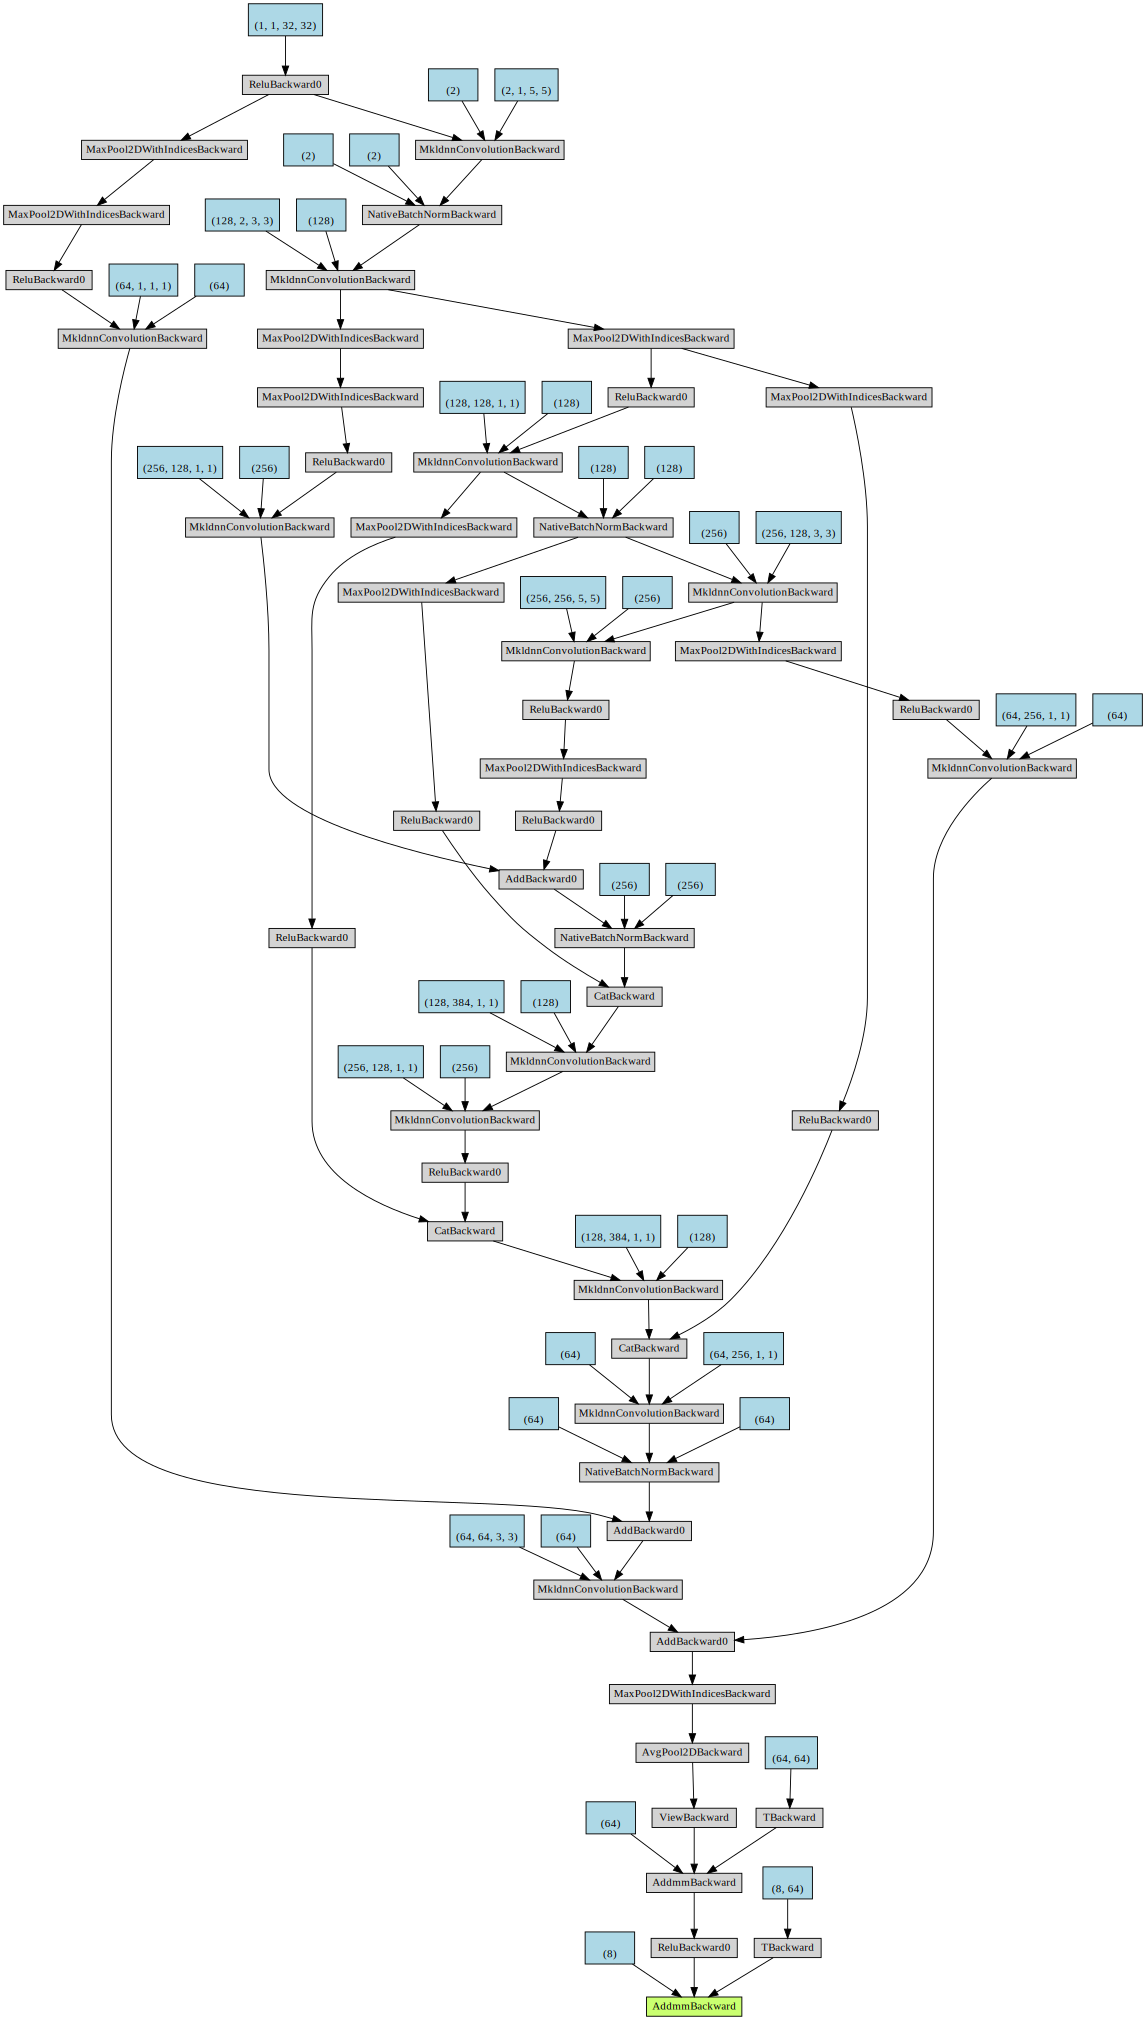

In [13]:
best_id = tuner.get_best_model_id()
best_graph = tuner.load_model_by_id(best_id, load_weights=True)
best_model = best_graph.produce_torch_model()
best_model.eval()

params = sum([p.numel() for p in best_model.parameters()])
print("parameters in best model:", params)

x,y = test_set[0]
x.unsqueeze_(0)
z = torch.zeros_like(x, requires_grad=True)

make_dot(best_model(z))